# Training the SPOCK model

In [1]:
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn import metrics
from sklearn.model_selection import train_test_split
import xgboost as xgb
from xgboost.sklearn import XGBRegressor
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials
import hyperopt

from hadden_theory.test_particle_secular_hamiltonian import SyntheticSecularTheory, TestParticleSecularHamiltonian, calc_g0_and_s0
from hadden_theory import test_particle_secular_hamiltonian
# hack to make pickle load work
import sys
sys.modules['test_particle_secular_hamiltonian'] = test_particle_secular_hamiltonian

try:
    plt.style.use('/Users/dtamayo/.matplotlib/paper.mplstyle')
except:
    pass

In [37]:
import pickle
with open("hadden_theory/solar_system_synthetic_solution.bin","rb") as fi:
    solar_system_synthetic_theory=pickle.load(fi)

In [39]:
truncate_dictionary = lambda d,tol: {key:val for key,val in d.items() if np.abs(val)>tol}
simpler_secular_theory = SyntheticSecularTheory(
    solar_system_synthetic_theory.masses,
    solar_system_synthetic_theory.semi_major_axes,
    solar_system_synthetic_theory.omega_vector,
    [truncate_dictionary(x_d,1e-3) for x_d in solar_system_synthetic_theory.x_dicts],
    [truncate_dictionary(y_d,1e-3) for y_d in solar_system_synthetic_theory.y_dicts]
)

In [48]:
# Read the table with the defined column specifications
df = pd.read_fwf('MPCORB.DAT', colspecs=[[0,7], [8,14], [15,19], [20,25], [26,35], [36,46], [47, 57], [58,68], [69,81], [82, 91], [92, 103]])
df = df[df['Epoch'] == 'K239D'] # take only ones at common epoch--almost all of them
for c in ['a', 'e', 'Incl.', 'Node', 'Peri.', 'M']:
	df[c] = pd.to_numeric(df[c])
df.head()

Des'n     H     G  Epoch          M      Peri.       Node     Incl.  \
1  00001  3.34  0.15  K239D   60.07879   73.42179   80.25496  10.58688   
2  00002  4.12  0.15  K239D   40.59806  310.87290  172.91881  34.92584   
3  00003  5.17  0.15  K239D   37.02310  247.73791  169.83920  12.99055   
4  00004  3.22  0.15  K239D  169.35183  151.66223  103.71002   7.14218   
5  00005  7.00  0.15  K239D  303.39802  359.13666  141.46909   5.35867   

          e          n         a  
1  0.078913  .21410680  2.767254  
2  0.230229  .21377378  2.770128  
3  0.256213  .22600445  2.669263  
4  0.089449  .27152244  2.361922  
5  0.187439  .23826556  2.576886

evectors, ivectors
relative to the planet
add variance of a, res osc will shift sec

In [49]:
labels = pd.read_fwf('proper_catalog24.dat', colspecs=[[0,10], [10,18], [19,28], [29,37], [38, 46], [47,55], [56,66], [67,78], [79,85], [86, 89], [90, 97]], header=None, index_col=False, names=['propa', 'da', 'prope', 'de', 'propsini', 'dsini', 'g', 's', 'H', 'NumOpps', "Des'n"])
labels.head()

propa            da     prope       de  propsini     dsini          g  \
0  2.767028  2.300000e-05  0.115193  0.00016  0.167560  0.000013  54.253800   
1  2.771276  1.200000e-04  0.280234  0.00034  0.546016  0.000045  -1.372312   
2  2.669376  7.500000e-06  0.233600  0.00001  0.229144  0.000003  43.858531   
3  2.361512  5.900000e-08  0.099452  0.00014  0.111023  0.000180  36.882605   
4  2.577657  2.900000e-05  0.171249  0.01200  0.076113  0.001400  52.506470   

           s     H  NumOpps  Des'n  
0 -59.249995  3.34      123  00001  
1 -46.451120  4.12      121  00002  
2 -61.476025  5.17      114  00003  
3 -39.610314  3.22      110  00004  
4 -51.132322  7.00       87  00005

In [43]:
integration_path = Path("integrations/ecc_inc_integrations")
file_names = list(integration_path.glob("*.npz"))
rows = []

for i in range(len(file_names)):
    soln_h = np.load(file_names[i])
    y = soln_h["arr_1"]
    prope_value = np.average(np.abs((y[9] - 1j * y[0]) / np.sqrt(2)))
    propsini_value = np.average(np.abs((y[1+9] - 1j * y[1]) / np.sqrt(2)))
    des_n = file_names[i].stem.replace("integration_results_", "")
    rows.append([des_n, prope_value, propsini_value])

df_h = pd.DataFrame(rows, columns=["Des'n", "prope_h", "propsini_h"])

In [50]:
merged_full_df = pd.merge(df, labels, on="Des'n", how="inner")
merged_full_df = pd.merge(merged_full_df, df_h, on="Des'n", how="inner")
merged_full_df.shape, labels.shape

((103203, 23), (1249051, 11))

In [45]:
merged_full_df[(merged_full_df['prope_h'] - merged_full_df['prope'])/merged_full_df['prope']>1]

Des'n    H_x     G  Epoch          M      Peri.       Node     Incl.  \
39      00040   6.55  0.15  K239D  210.11613  269.07148   94.15865   4.25553   
71      00072   9.11  0.15  K239D  108.80870  103.00771  207.93446   5.41847   
86      00087   6.96  0.15  K239D  334.81925  264.40300   73.01222  10.88030   
109     00110   7.91  0.15  K239D  197.01120  282.23632   56.77086   5.95987   
135     00136   9.80  0.15  K239D  313.08930  132.72752  186.40219   9.58067   
...       ...    ...   ...    ...        ...        ...        ...       ...   
102876  V3403  16.56  0.15  K239D  339.20801   69.68596  322.23340  28.51445   
102886  V3413  15.02  0.15  K239D   85.62071  185.36044  144.78670  15.79305   
102890  V3417  16.71  0.15  K239D  165.81302  346.20504  288.86443   8.63358   
102963  V3490  17.20  0.15  K239D  125.52778  178.48806  111.35308  14.19852   
103136  V3668  15.21  0.15  K239D  273.77684   57.67591  183.79095   7.13897   

               e          n  ...     prope        de  propsini     dsini  \
39      0.046210  .28864981  ...  0.020955  0.000190  0.065183  0.000031   
71      0.121318  .28890519  ...  0.073572  0.000270  0.103208  0.000250   
86      0.093892  .15201625  ...  0.054077  0.000020  0.170895  0.000002   
109     0.079730  .21814725  ...  0.045066  0.001500  0.089019  0.000730   
135     0.084394  .28500582  ...  0.018432  0.000250  0.173369  0.000099   
...          ...        ...  ...       ...       ...       ...       ...   
102876  0.353584  .23643691  ...  0.101220  0.000220  0.515434  0.000031   
102886  0.068230  .15292036  ...  0.055624  0.000016  0.256620  0.000002   
102890  0.033266  .25074798  ...  0.028305  0.000340  0.162822  0.000091   
102963  0.066047  .23823714  ...  0.060429  0.000024  0.229592  0.000001   
103136  0.037074  .16997682  ...  0.038582  0.000003  0.123472  0.000002   

                 g           s    H_y  NumOpps   prope_h  propsini_h  
39       34.768528  -35.198622   6.55       78  0.053852    0.079179  
71       33.893666  -35.556858   9.11       66  0.165236    0.113096  
86      134.875041 -130.862018   6.96       77  0.112878    0.190548  
109      58.119053  -56.297173   7.91       71  0.097941    0.099361  
135      31.891828  -34.818274   9.80       60  0.146849    0.187487  
...            ...         ...    ...      ...       ...         ...  
102876  -85.789058  -40.766004  16.56        8  0.240309    0.519341  
102886   93.876576 -108.551864  15.02       16  0.113228    0.267623  
102890   60.060826  -41.560554  16.71       15  0.084491    0.146521  
102963   40.556315  -44.623785  17.20       11  0.127651    0.248967  
103136  366.147202  -79.635220  15.21       14  0.077765    0.133121  

[4750 rows x 23 columns]

(0.0, 10.0)

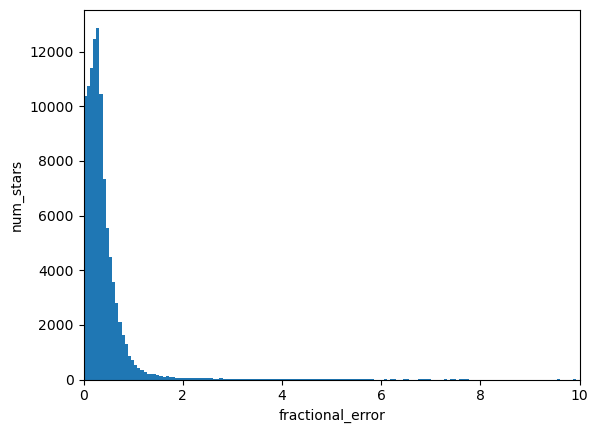

In [51]:
fractional_error = np.abs((merged_full_df['prope_h'] - merged_full_df['prope'])/merged_full_df['prope'])

plt.hist(fractional_error, bins = 1000)
plt.xlabel("fractional_error")
plt.ylabel("num_stars")
plt.xlim(0, 10)

In [149]:
merged_df_low = merged_full_df[(merged_full_df['prope_h'] - merged_full_df['prope'])/merged_full_df['prope'] < 1]
merged_df_low.to_csv("merged dataframe with low percentage error")

In [150]:
merged_df_high = merged_full_df[np.abs((merged_full_df['prope_h'] - merged_full_df['prope'])/merged_full_df['prope'])>0.5]
merged_df_high.to_csv("merged dataframe with high percentage error")

In [145]:
import numpy as np
from itertools import product, combinations_with_replacement

asteroids_g = merged_df_high['g'].tolist()
asteroids_a = merged_df_high['a'].tolist()
diff = 0.5
percentage = 0.01
multiples = list(range(-3, 4))

def k_vec_generation(max_order = 3, size = 7):
    kvecs = []
    
    for order in range(1, max_order + 1):
        for positions in combinations_with_replacement(range(size), order):
            for variables in combinations_with_replacement([-1, 1], order):
                k = np.zeros(size, dtype = int)
                for i, n in zip(positions, variables):
                    k[i] += n
                kvecs.append(k)
    kvecs = np.array(kvecs)
    indices = np.where((kvecs == np.zeros(size)).all(axis = 1))
    kvecs = np.delete(kvecs, indices, axis=0)
    return kvecs

use_k_vecs = False
resonances_high = []

for i in range(len(merged_df_high)):
    a_ast = asteroids_a[i]
    g_ast = asteroids_g[i]
    tp_h = TestParticleSecularHamiltonian(asteroids_a[i],simpler_secular_theory)
    sorted_solutions = sorted(tp_h.F_e.items(), key=lambda item: np.abs(item[1]), reverse=True)
    planets_g = []
    for m, amp in sorted_solutions:
        freq = np.dot(m, solar_system_synthetic_theory.omega_vector) * 60*60*180 / np.pi * (2*np.pi)
        planets_g.append(freq)
    k_vecs = k_vec_generation(max_order = 3, size = len(planets_g))
    found_resonance = False
    for k in k_vecs:
        resonance_combo = np.dot(k, planets_g)
        if np.abs((g_ast - resonance_combo)/g_ast) < percentage:
            print(f"Asteroid {i} is in resonance: g_ast = {g_ast:.6f}, the resonance is {resonance_combo} with vector {k}")
            found_resonance = True
            resonances_high.append([i, g_ast, resonance_combo, k])
            break

    if not found_resonance:
        print(f"Asteroid {i} not in resonance.")


Asteroid 0 is in resonance: g_ast = 31.540156, the resonance is 31.362905674666816 with vector [0 1 1 0 0]
Asteroid 1 is in resonance: g_ast = 32.049097, the resonance is 32.03569340649081 with vector [1 0 1 0 1]
Asteroid 2 not in resonance.
Asteroid 3 is in resonance: g_ast = 53.886490, the resonance is 53.646714483161325 with vector [0 0 0 1 2]
Asteroid 4 is in resonance: g_ast = 34.768528, the resonance is 34.4523763520703 with vector [1 0 2 0 0]
Asteroid 5 is in resonance: g_ast = 32.599765, the resonance is 32.51916597227666 with vector [1 1 0 0 0]
Asteroid 6 is in resonance: g_ast = 105.422428, the resonance is 104.60227803902669 with vector [0 0 0 2 0]
Asteroid 7 is in resonance: g_ast = 53.222708, the resonance is 52.97392675133733 with vector [0 0 0 1 1]
Asteroid 8 not in resonance.
Asteroid 9 is in resonance: g_ast = 55.802734, the resonance is 55.390609696916826 with vector [0 0 1 1 0]
Asteroid 10 not in resonance.
Asteroid 11 not in resonance.
Asteroid 12 is in resonance: g

In [147]:
import numpy as np
from itertools import product, combinations_with_replacement

asteroids_g = merged_df_low['g'].tolist()
asteroids_a = merged_df_low['a'].tolist()
diff = 0.5
percentage = 0.01
multiples = list(range(-3, 4))

def k_vec_generation(max_order = 3, size = 7):
    kvecs = []
    
    for order in range(1, max_order + 1):
        for positions in combinations_with_replacement(range(size), order):
            for variables in combinations_with_replacement([-1, 1], order):
                k = np.zeros(size, dtype = int)
                for i, n in zip(positions, variables):
                    k[i] += n
                kvecs.append(k)
    kvecs = np.array(kvecs)
    indices = np.where((kvecs == np.zeros(size)).all(axis = 1))
    kvecs = np.delete(kvecs, indices, axis=0)
    return kvecs

use_k_vecs = False
resonances_low = []

for i in range(len(merged_df_low)):
    a_ast = asteroids_a[i]
    g_ast = asteroids_g[i]
    tp_h = TestParticleSecularHamiltonian(asteroids_a[i],simpler_secular_theory)
    sorted_solutions = sorted(tp_h.F_e.items(), key=lambda item: np.abs(item[1]), reverse=True)
    planets_g = []
    for m, amp in sorted_solutions:
        freq = np.dot(m, solar_system_synthetic_theory.omega_vector) * 60*60*180 / np.pi * (2*np.pi)
        planets_g.append(freq)
    k_vecs = k_vec_generation(max_order = 3, size = len(planets_g))
    found_resonance = False
    for k in k_vecs:
        resonance_combo = np.dot(k, planets_g)
        if np.abs((g_ast - resonance_combo)/g_ast) < percentage:
            print(f"Asteroid {i} is in resonance: g_ast = {g_ast:.6f}, the resonance is {resonance_combo} with vector {k}")
            found_resonance = True
            resonances_low.append([i, g_ast, resonance_combo, k])
            break

    if not found_resonance:
        print(f"Asteroid {i} not in resonance.")


Asteroid 0 not in resonance.
Asteroid 1 not in resonance.
Asteroid 2 is in resonance: g_ast = 43.858531, the resonance is 43.80967706948669 with vector [-2  0  1  0  0]
Asteroid 3 is in resonance: g_ast = 36.882605, the resonance is 36.764896947289984 with vector [1 2 0 0 0]
Asteroid 4 is in resonance: g_ast = 52.506470, the resonance is 52.30113901951334 with vector [0 0 0 1 0]
Asteroid 5 is in resonance: g_ast = 31.540156, the resonance is 31.362905674666816 with vector [0 1 1 0 0]
Asteroid 6 not in resonance.
Asteroid 7 is in resonance: g_ast = 32.049097, the resonance is 32.03569340649081 with vector [1 0 1 0 1]
Asteroid 8 not in resonance.
Asteroid 9 not in resonance.
Asteroid 10 not in resonance.
Asteroid 11 is in resonance: g_ast = 34.152919, the resonance is 34.4523763520703 with vector [1 0 2 0 0]
Asteroid 12 is in resonance: g_ast = 35.937744, the resonance is 35.60863664968014 with vector [1 1 1 0 0]
Asteroid 13 is in resonance: g_ast = 48.841992, the resonance is 49.2116683

In [ ]:
len(resonances_high)/len(merged_df_high['g'])

0.4832262041031963

In [148]:
len(resonances_low)/len(merged_df_low['g'])

0.4237554975470529

In [88]:
merged_df = merged_df_high

In [89]:
merged_df["g0"] = merged_df['a'].apply(lambda x: calc_g0_and_s0(x, simpler_secular_theory)[0])

/tmp/ipykernel_269588/3737764660.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_df["g0"] = merged_df['a'].apply(lambda x: calc_g0_and_s0(x, simpler_secular_theory)[0])


In [90]:
merged_df['ecospo'] = merged_df['prope_h']*np.cos((merged_df['Node']+merged_df['Peri.'])*np.pi/180)
merged_df['esinpo'] = merged_df['prope_h']*np.sin((merged_df['Node']+merged_df['Peri.'])*np.pi/180)
merged_df['sinicosO'] = np.sin(merged_df['propsini_h']*np.pi/180)*np.cos(merged_df['Node']*np.pi/180)
merged_df['sinisinO'] = np.sin(merged_df['propsini_h']*np.pi/180)*np.sin(merged_df['Node']*np.pi/180)

/tmp/ipykernel_269588/2614236503.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_df['ecospo'] = merged_df['prope_h']*np.cos((merged_df['Node']+merged_df['Peri.'])*np.pi/180)
/tmp/ipykernel_269588/2614236503.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_df['esinpo'] = merged_df['prope_h']*np.sin((merged_df['Node']+merged_df['Peri.'])*np.pi/180)
/tmp/ipykernel_269588/2614236503.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .

In [ ]:
merged_df.to_csv("integrations/merged_elements.csv")

In [23]:
merged_df = pd.read_csv("integrations/merged_elements.csv")
merged_df.columns

/tmp/ipykernel_269588/2756484719.py:1: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  merged_df = pd.read_csv("integrations/merged_elements.csv")


Index(['Unnamed: 0', 'Des'n', 'H_x', 'G', 'Epoch', 'M', 'Peri.', 'Node',
       'Incl.', 'e', 'n', 'a', 'propa', 'da', 'prope', 'de', 'propsini',
       'dsini', 'g', 's', 'H_y', 'NumOpps', 'prope_h', 'propsini_h', 'g0',
       'ecospo', 'esinpo', 'sinicosO', 'sinisinO'],
      dtype='object')

In [91]:
#features = ['M', 'Peri.', 'Node', 'Incl.', 'e', 'a']
#features = ['M', 'Peri.', 'Node', 'Incl.', 'e', 'propa']
#features = ['M', 'Node', 'Incl.', 'ecospo', 'esinpo', 'propa']
features = ['sinicosO', 'sinisinO', 'ecospo', 'esinpo', 'propa', 'g0']
data = merged_df[features]
dela = merged_df['propa']-merged_df['a']
dele = merged_df['prope']-merged_df['prope_h']
delsini = merged_df['propsini_h']-np.sin(merged_df['Incl.']*np.pi/180)
delg = merged_df['g0'] - merged_df['g']
s = merged_df['s']

In [92]:
trainX, testX, trainY, testY = train_test_split(data, dele, test_size=0.2, random_state=42)

In [93]:
trainY.shape

(18171,)

In [94]:
dtrain = xgb.DMatrix(trainX, trainY)
dtest = xgb.DMatrix(testX, testY)

# Tuning hyperparameter
We will start by creating and testing a collection of models that have randomly selected hyperparameters.
We establish the different parameter space that we will be testing different hyperparameter values within.

In [95]:
space ={'max_depth': hp.qloguniform('x_max_depth', np.log(5), np.log(40), 1),
        'min_child_weight': hp.loguniform('x_min_child', 0, np.log(30)),
        'subsample': hp.uniform ('x_subsample', 0.8, 1),
}

def objective(params):
    clf = XGBRegressor(n_estimators = 50,
                            max_depth = int(params['max_depth']), 
                            min_child_weight = params['min_child_weight'],
                            subsample = params['subsample'],
                            learning_rate = 0.15, seed = 0,)
    
    score = xgb.cv(clf.get_xgb_params(), dtrain, nfold = 5, metrics = "rmse", early_stopping_rounds=10)
    avg_score =  np.mean(score["test-rmse-mean"])
    error = np.mean(score["test-rmse-std"])
    
    print("SCORE:", avg_score, "+/-", error)#, "HOLDOUT SCORE", test_score)
    return{'loss':1-avg_score, 'status': STATUS_OK, "cv_score":avg_score , "cv_error":error}


We can now run an array of different parameter combinations

In [96]:
%%time
trials = Trials()
import time
start = time.time()
best = fmin(fn=objective, space = space, algo = tpe.suggest, max_evals = 10, trials = trials, rstate=np.random.default_rng(seed=0))
end = time.time()
print("Optimization Time: %f seconds", (end  -start))

SCORE:                                                
0.05128290719037698                                   
+/-                                                   
0.008244694751526265                                  
SCORE:                                                                         
0.051388321072881146                                                           
+/-                                                                            
0.008026818373046102                                                           
SCORE:                                                                          
0.05211674249772846                                                             
+/-                                                                             
0.010284878038779494                                                            
SCORE:                                                                          
0.05092868731354314                                    

In [97]:
best

{'x_max_depth': 6.0,
 'x_min_child': 29.027212358902943,
 'x_subsample': 0.9458899808537233}

In [98]:
model = XGBRegressor(learning_rate = 0.05, 
                         max_depth = 6, 
                         subsample = 0.946,
                         min_child_weight = 29.03)

score = xgb.cv(model.get_xgb_params(), dtrain, nfold = 5, metrics = "rmse", verbose_eval=True, num_boost_round=500)

[0]	train-rmse:0.08481+0.00165	test-rmse:0.08459+0.00678
[1]	train-rmse:0.08166+0.00170	test-rmse:0.08145+0.00705
[1]	train-rmse:0.08166+0.00170	test-rmse:0.08145+0.00705
[2]	train-rmse:0.07864+0.00172	test-rmse:0.07847+0.00736
[3]	train-rmse:0.07575+0.00173	test-rmse:0.07556+0.00769
[4]	train-rmse:0.07303+0.00174	test-rmse:0.07282+0.00799
[5]	train-rmse:0.07051+0.00172	test-rmse:0.07032+0.00836
[6]	train-rmse:0.06809+0.00177	test-rmse:0.06791+0.00859
[7]	train-rmse:0.06583+0.00184	test-rmse:0.06561+0.00884
[8]	train-rmse:0.06376+0.00184	test-rmse:0.06355+0.00915
[9]	train-rmse:0.06180+0.00193	test-rmse:0.06158+0.00936
[10]	train-rmse:0.05989+0.00196	test-rmse:0.05965+0.00962
[11]	train-rmse:0.05812+0.00200	test-rmse:0.05784+0.00989
[12]	train-rmse:0.05647+0.00201	test-rmse:0.05619+0.01014
[13]	train-rmse:0.05490+0.00205	test-rmse:0.05462+0.01037
[14]	train-rmse:0.05345+0.00209	test-rmse:0.05313+0.01059
[15]	train-rmse:0.05211+0.00214	test-rmse:0.05180+0.01077
[16]	train-rmse:0.05085+0

# n_estimators (number of trees) tuning

Text(0, 0.5, 'CV AUC score')

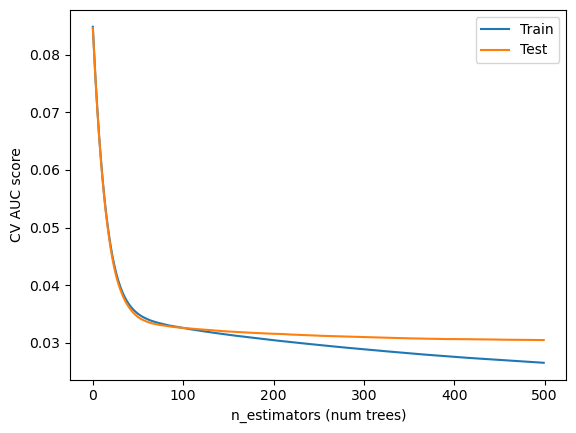

In [99]:
n_estimators = 100
fig, ax = plt.subplots()
ax.plot(score.index, score['train-rmse-mean'], label='Train')
ax.plot(score.index, score['test-rmse-mean'], label='Test')
#ax.axvline(n_estimators, linestyle='--')
ax.legend()
ax.set_xlabel('n_estimators (num trees)')
ax.set_ylabel('CV AUC score')

Text(0, 0.5, 'CV AUC score')

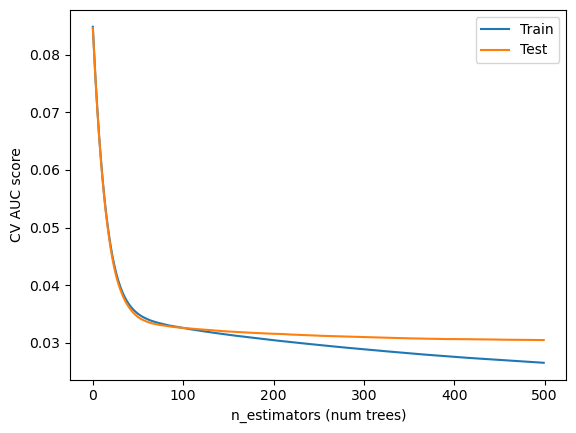

In [100]:
n_estimators = 100
fig, ax = plt.subplots()
ax.plot(score.index, score['train-rmse-mean'], label='Train')
ax.plot(score.index, score['test-rmse-mean'], label='Test')
#ax.axvline(n_estimators, linestyle='--')
ax.legend()
ax.set_xlabel('n_estimators (num trees)')
ax.set_ylabel('CV AUC score')

Text(0, 0.5, 'CV AUC score')

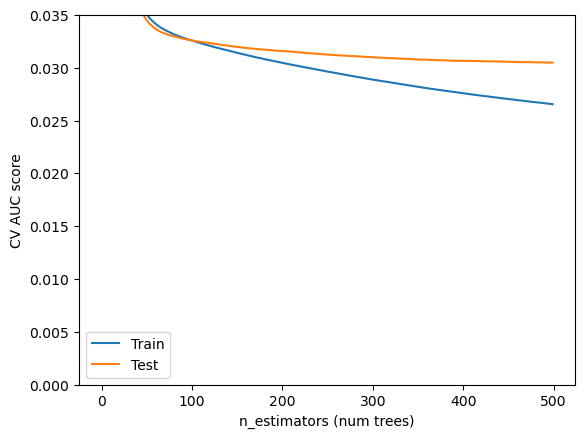

In [118]:
n_estimators = 100
fig, ax = plt.subplots()
ax.plot(score.index, score['train-rmse-mean'], label='Train')
ax.plot(score.index, score['test-rmse-mean'], label='Test')
#ax.axvline(n_estimators, linestyle='--')
ax.legend()
ax.set_ylim(0, 0.035)
ax.set_xlabel('n_estimators (num trees)')
ax.set_ylabel('CV AUC score')

Text(0, 0.5, 'CV AUC score')

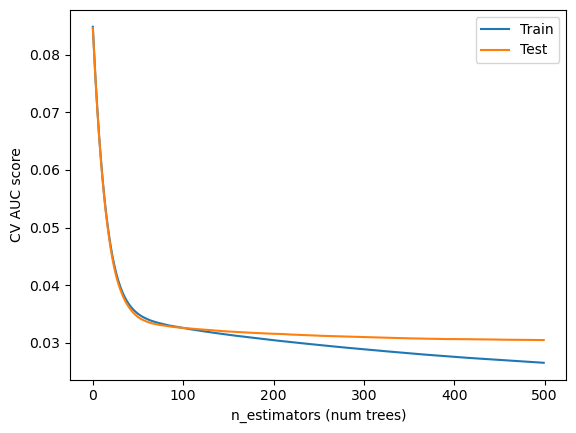

In [102]:
n_estimators = 100
fig, ax = plt.subplots()
ax.plot(score.index, score['train-rmse-mean'], label='Train')
ax.plot(score.index, score['test-rmse-mean'], label='Test')
#ax.axvline(n_estimators, linestyle='--')
ax.legend()
ax.set_xlabel('n_estimators (num trees)')
ax.set_ylabel('CV AUC score')

Text(0, 0.5, 'CV AUC score')

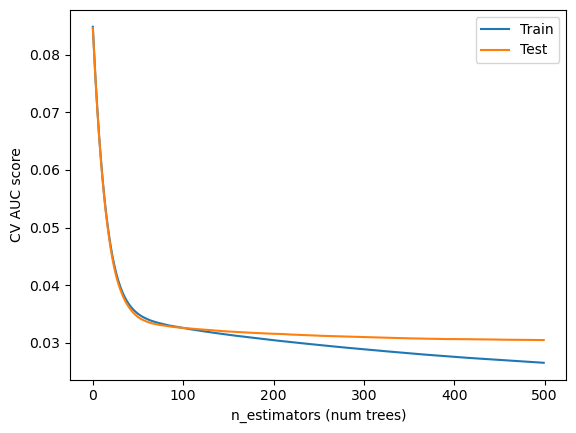

In [103]:
n_estimators = 100
fig, ax = plt.subplots()
ax.plot(score.index, score['train-rmse-mean'], label='Train')
ax.plot(score.index, score['test-rmse-mean'], label='Test')
#ax.axvline(n_estimators, linestyle='--')
ax.legend()
ax.set_xlabel('n_estimators (num trees)')
ax.set_ylabel('CV AUC score')

In [104]:
#model.set_params(n_estimators = 10, max_depth = int(best['x_max_depth']), subsample = best['x_subsample'], min_child_weight = best['x_min_child'])
model= xgb.train(dtrain=dtrain, params=model.get_params(), num_boost_round=2000)

/home/miniconda3/envs/lshen/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [20:55:48] WARNING: /croot/xgboost-split_1724073744422/work/src/learner.cc:740: 
Parameters: { "enable_categorical", "missing" } are not used.

  warnings.warn(smsg, UserWarning)


In [105]:
%%time
pred = model.predict(dtest)

CPU times: user 537 ms, sys: 18.3 ms, total: 555 ms
Wall time: 9.14 ms


In [106]:
np.std(pred-testY)

0.01917179670789813

Text(0.5, 0, 'Prop e')

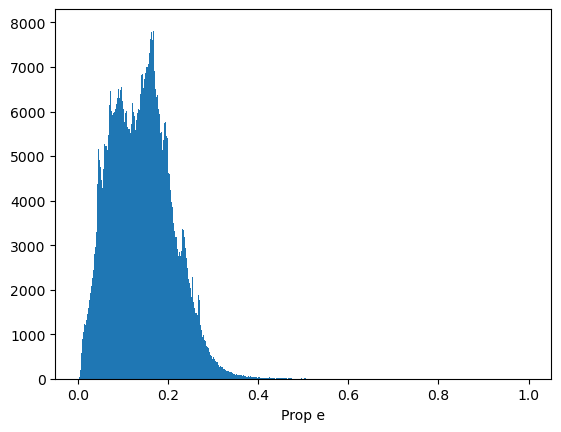

In [107]:
fig, ax = plt.subplots()
_, _, _ = ax.hist(labels['prope'], bins=np.linspace(0, 1, 1000))
ax.set_xlabel('Prop e')

Text(0.5, 0, 'Nesvorny Proper Eccentricity Correction')

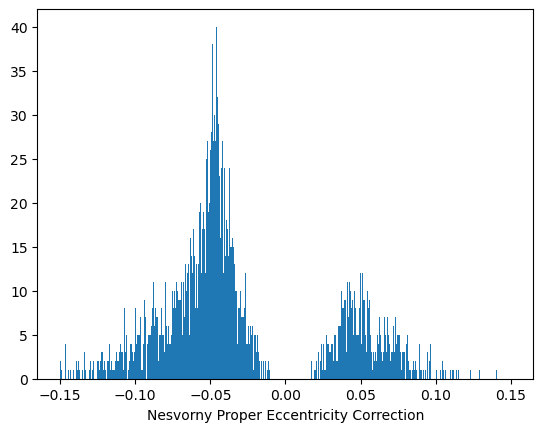

In [108]:
fig, ax = plt.subplots()
_, _, _ = ax.hist(testY, bins=np.linspace(-0.15, 0.15, 1000))
ax.set_xlabel('Nesvorny Proper Eccentricity Correction')

Text(0.5, 0, 'Correction Error (Model-Nesvorny)')

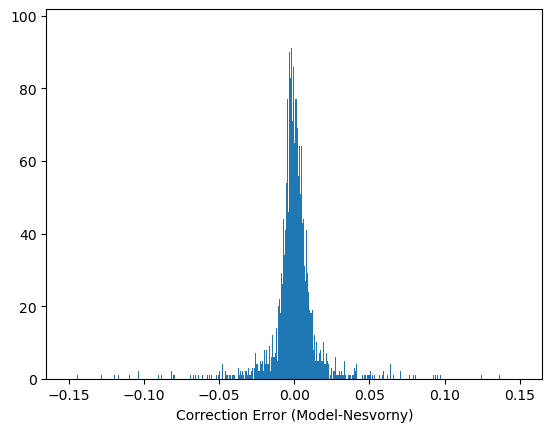

In [119]:
fig, ax = plt.subplots()
_, _, _ = ax.hist(pred-testY, bins=np.linspace(-0.15, 0.15, 1000))
ax.set_xlabel('Correction Error (Model-Nesvorny)')


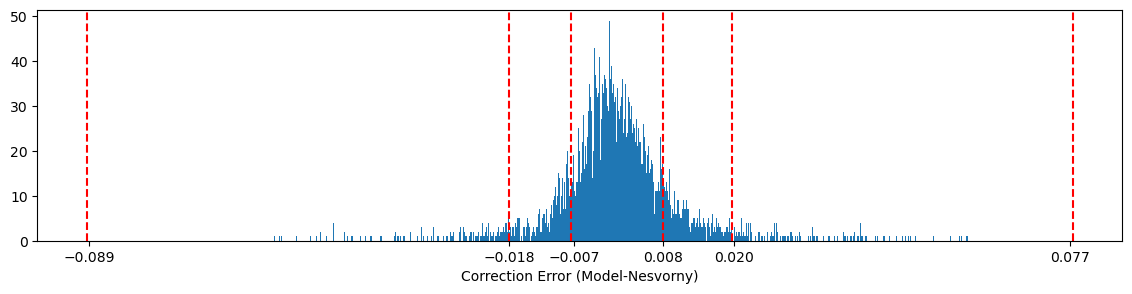

In [120]:
fig, ax = plt.subplots(figsize=(14,3))
_, _, _ = ax.hist(pred-testY, bins=np.linspace(-0.06, 0.06, 1000))
ax.set_xlabel('Correction Error (Model-Nesvorny)')
percentiles = [0.5, 5, 16, 84, 95, 99.5]
for p in percentiles:
    val = np.percentile(pred-testY, p)
    ax.axvline(val, linestyle='--', color='r')
_ = ax.set_xticks(np.round(np.percentile(pred-testY, percentiles), decimals=3))

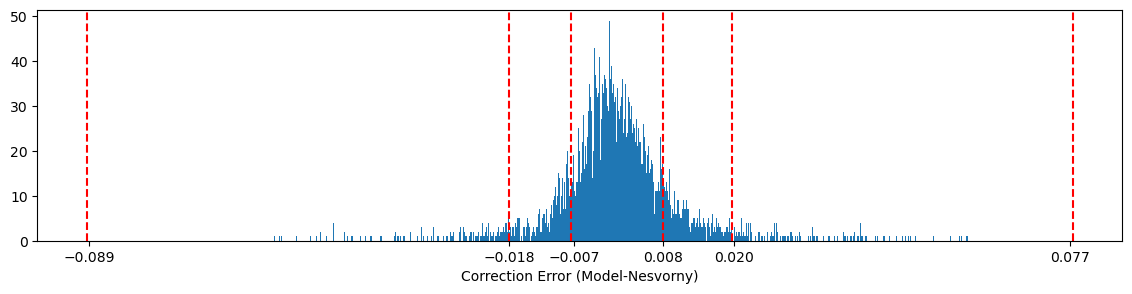

In [121]:
fig, ax = plt.subplots(figsize=(14,3))
_, _, _ = ax.hist(pred-testY, bins=np.linspace(-0.06, 0.06, 1000))
ax.set_xlabel('Correction Error (Model-Nesvorny)')
percentiles = [0.5, 5, 16, 84, 95, 99.5]
for p in percentiles:
    val = np.percentile(pred-testY, p)
    ax.axvline(val, linestyle='--', color='r')
_ = ax.set_xticks(np.round(np.percentile(pred-testY, percentiles), decimals=3))

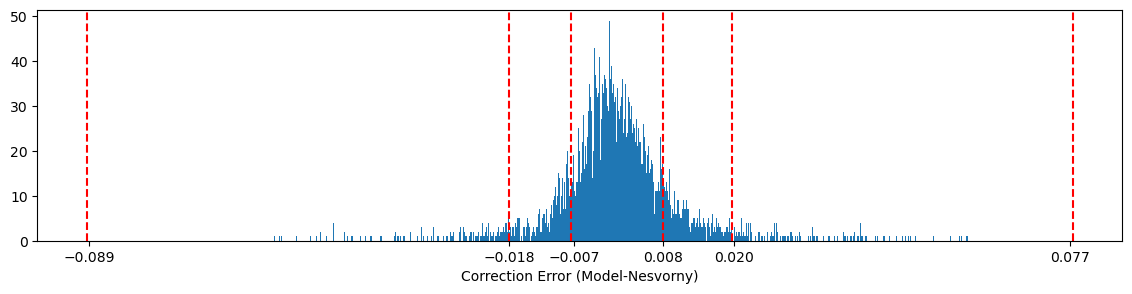

In [122]:
fig, ax = plt.subplots(figsize=(14,3))
_, _, _ = ax.hist(pred-testY, bins=np.linspace(-0.06, 0.06, 1000))
ax.set_xlabel('Correction Error (Model-Nesvorny)')
percentiles = [0.5, 5, 16, 84, 95, 99.5]
for p in percentiles:
    val = np.percentile(pred-testY, p)
    ax.axvline(val, linestyle='--', color='r')
_ = ax.set_xticks(np.round(np.percentile(pred-testY, percentiles), decimals=3))

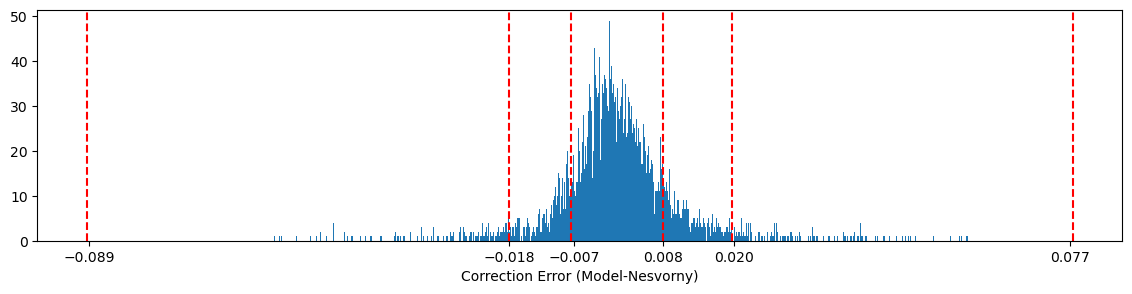

In [123]:
fig, ax = plt.subplots(figsize=(14,3))
_, _, _ = ax.hist(pred-testY, bins=np.linspace(-0.06, 0.06, 1000))
ax.set_xlabel('Correction Error (Model-Nesvorny)')
percentiles = [0.5, 5, 16, 84, 95, 99.5]
for p in percentiles:
    val = np.percentile(pred-testY, p)
    ax.axvline(val, linestyle='--', color='r')
_ = ax.set_xticks(np.round(np.percentile(pred-testY, percentiles), decimals=3))

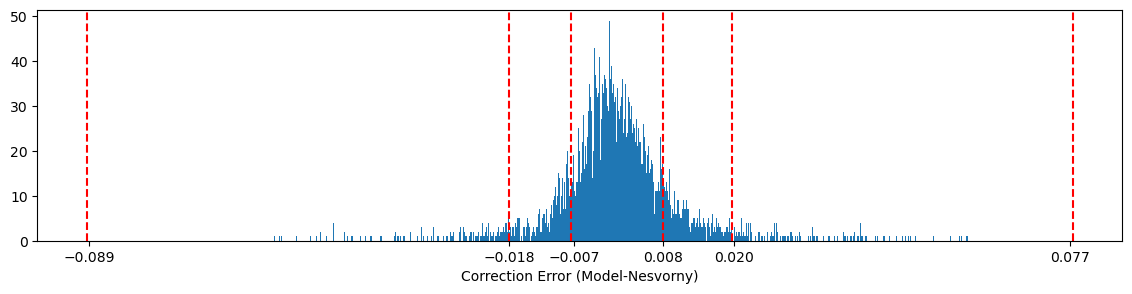

In [124]:
fig, ax = plt.subplots(figsize=(14,3))
_, _, _ = ax.hist(pred-testY, bins=np.linspace(-0.06, 0.06, 1000))
ax.set_xlabel('Correction Error (Model-Nesvorny)')
percentiles = [0.5, 5, 16, 84, 95, 99.5]
for p in percentiles:
    val = np.percentile(pred-testY, p)
    ax.axvline(val, linestyle='--', color='r')
_ = ax.set_xticks(np.round(np.percentile(pred-testY, percentiles), decimals=3))

In [125]:
(pred-testY).min()

-0.24242278845439758

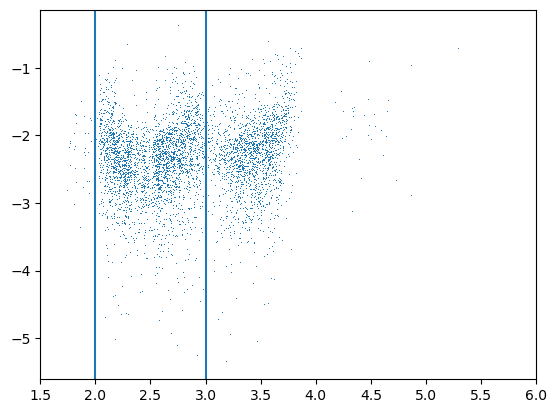

In [116]:
aJup = 5.202263784717109
fig, ax = plt.subplots()
ax.plot((aJup/testX['propa'])**(3/2), np.log10(np.abs(pred-testY)), ',')
ax.set_xlim([1.5, 6])
ax.axvline(2)
ax.axvline(3)

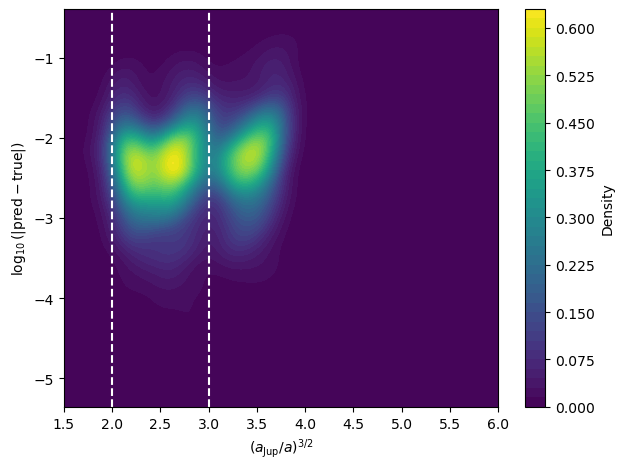

In [117]:
from scipy.stats import gaussian_kde

# Compute your X and Y data
x = (aJup / testX['propa'])**(3/2)
y = np.log10(np.abs(pred - testY))

# Stack the data for KDE
xy = np.vstack([x, y])
kde = gaussian_kde(xy)

# Create a grid over the plot range
xgrid = np.linspace(1.5, 6, 200)
ygrid = np.linspace(np.min(y), np.max(y), 200)
Xgrid, Ygrid = np.meshgrid(xgrid, ygrid)
Z = kde(np.vstack([Xgrid.ravel(), Ygrid.ravel()])).reshape(Xgrid.shape)

# Plot
fig, ax = plt.subplots()
contour = ax.contourf(Xgrid, Ygrid, Z, levels=50, cmap='viridis')
ax.set_xlim([1.5, 6])
ax.axvline(2, color='white', linestyle='--')
ax.axvline(3, color='white', linestyle='--')
fig.colorbar(contour, ax=ax, label='Density')
ax.set_xlabel(r'$(a_\mathrm{Jup} / a)^{3/2}$')
ax.set_ylabel(r'$\log_{10}(|\mathrm{pred} - \mathrm{true}|)$')
plt.tight_layout()
plt.show()